## Predicting Stock Price Movements 

#### import all needed libraries for this project

In [1]:
import pandas as pd
import numpy as np
from data_processing import Training_Data
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
from ta import add_all_ta_features
from pykalman import KalmanFilter
import yfinance as yf

##### Using the yfinance historical data api to fetch stock price data in a given timeframe

In [2]:
spy = yf.Ticker("^GSPC")
df = spy.history(period="max", actions=False)

#### view dataframe from API response

In [3]:
df=df.reset_index()
df.head()


,Date,Open,High,Low,Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,2520000


#### figure 1:  SPY stock price since 2015-12-01

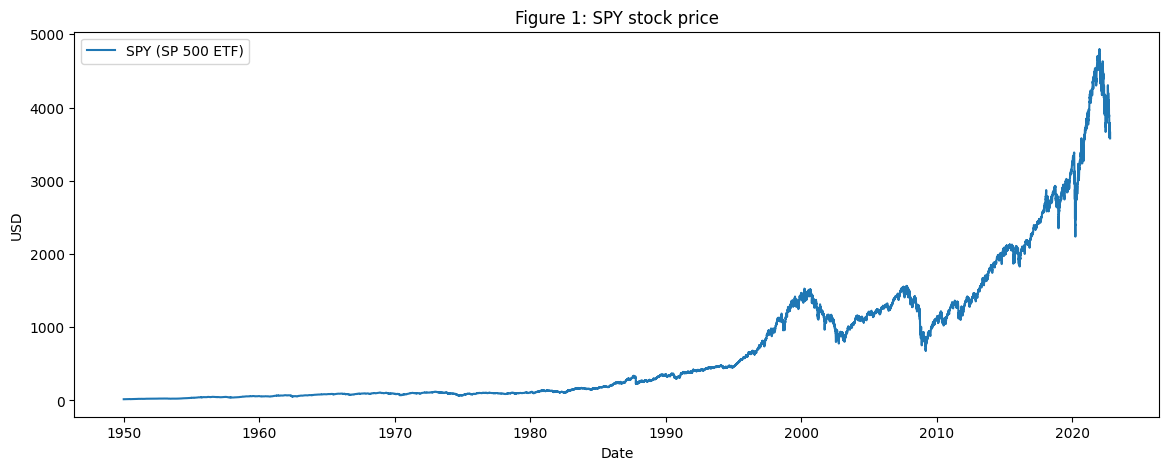

In [4]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='SPY (SP 500 ETF)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: SPY stock price')
plt.legend()
plt.show()

#### encode the timestamp with sin and cos to capture periodicity of the timeseries

In [5]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#### apply to both month and day

In [6]:
df['month'] = df.Date.dt.month
df = encode(df, 'month', 12)

df['day'] = df.Date.dt.day
df = encode(df, 'day', 31)

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,month,month_sin,month_cos,day,day_sin,day_cos
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,1,0.5,0.866025,3,0.571268,0.820763
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,1,0.5,0.866025,4,0.724793,0.688967
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,1,0.5,0.866025,5,0.848644,0.528964
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,1,0.5,0.866025,6,0.937752,0.347305
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,1,0.5,0.866025,9,0.968077,-0.250653


In [8]:
df = df.drop(columns=['month', 'day', 'Date'])

In [9]:
df.head()

,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos
0,16.66,16.66,16.66,16.66,1260000,0.5,0.866025,0.571268,0.820763
1,16.85,16.85,16.85,16.85,1890000,0.5,0.866025,0.724793,0.688967
2,16.93,16.93,16.93,16.93,2550000,0.5,0.866025,0.848644,0.528964
3,16.98,16.98,16.98,16.98,2010000,0.5,0.866025,0.937752,0.347305
4,17.08,17.08,17.08,17.08,2520000,0.5,0.866025,0.968077,-0.250653


#### For now, we add all technical indicators available in the ta library for exploration purposes. The less descriptive TI's will be discarded. 

In [10]:
# Add all ta features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'momentum_rsi', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'momentum_stoch', 'trend_macd', 'momentum_wr', 'momentum_rsi']]
df['pct_change'] = df['Close'].pct_change()
df = df.dropna()

#### in addition, we will also add kalman filter as a feature and eventually FinBERT (although sentiment is more difficult to attain, but we have done it before)

In [12]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
# Get the Kalman smoothing
state_means, _ = kf.filter(df['Close'].values)
state_means

array([[   8.61499977],
       [  11.51794656],
       [  13.00468167],
       ...,
       [3730.20087141],
       [3724.46569861],
       [3711.01545031]])

In [13]:
df['KF_mean'] = np.array(state_means)
df.head()


,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos,momentum_rsi,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,momentum_stoch,trend_macd,momentum_wr,momentum_rsi,pct_change,KF_mean
25,17.230000,17.230000,17.230000,17.230000,1360000,0.866025,0.5,0.988468,0.151428,66.029671,17.021667,16.942692,17.083470,16.961539,84.745741,0.121931,-15.254259,66.029671,-0.005196,8.615000
26,17.209999,17.209999,17.209999,17.209999,1470000,0.866025,0.5,0.998717,-0.050649,64.521775,17.045833,16.963846,17.102936,16.979944,81.355834,0.122993,-18.644166,64.521775,-0.001161,11.517947
27,17.280001,17.280001,17.280001,17.280001,1810000,0.866025,0.5,0.968077,-0.250653,67.333589,17.080833,16.980385,17.130177,17.002170,93.220509,0.128007,-6.779491,67.333589,0.004067,13.004682
28,17.240000,17.240000,17.240000,17.240000,1790000,0.866025,0.5,0.897805,-0.440394,64.202308,17.122500,16.992308,17.147073,17.019787,86.440694,0.127286,-13.559306,64.202308,-0.002315,13.899901
29,17.059999,17.059999,17.059999,17.059999,2210000,0.866025,0.5,0.299363,-0.954139,52.394620,17.150000,16.995385,17.133677,17.022766,55.932176,0.110911,-44.067824,52.394620,-0.010441,14.472660


Text(0, 0.5, 'Price')

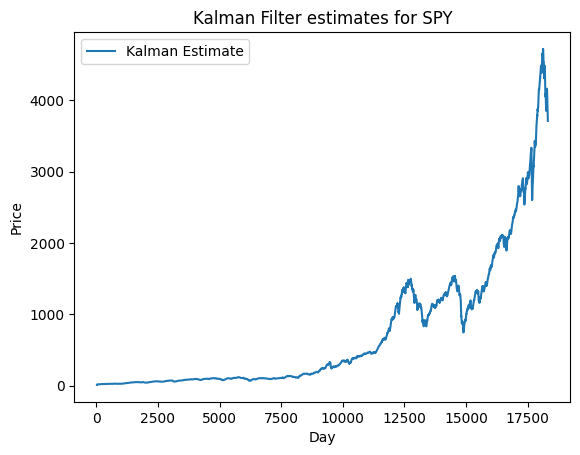

In [14]:
df[['KF_mean']].plot()
plt.title('Kalman Filter estimates for SPY')
plt.legend(['Kalman Estimate'])
plt.xlabel('Day')
plt.ylabel('Price')


Text(0.5, 1.0, 'Time of day signal')

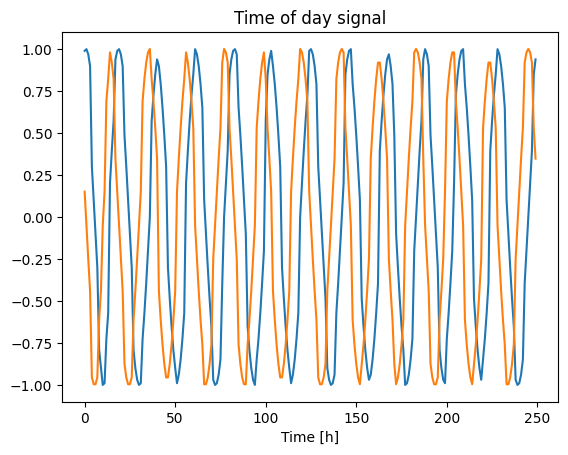

In [15]:
plt.plot(np.array(df['day_sin'])[:250])
plt.plot(np.array(df['day_cos'])[:250])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of month signal')

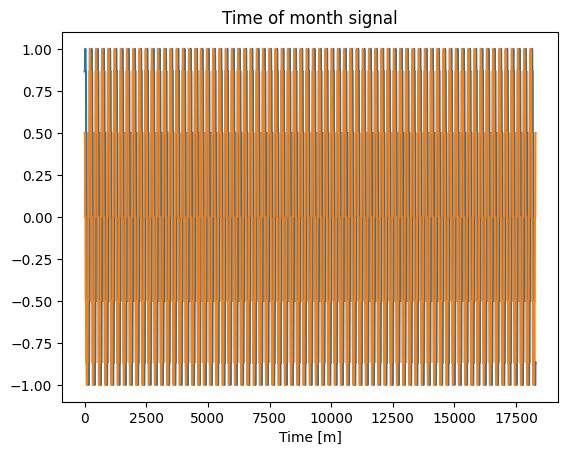

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(np.array(df['month_sin']))
plt.plot(np.array(df['month_cos']))
plt.xlabel('Time [m]')
plt.title('Time of month signal')

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,18291.0,7.019358e+02,9.737689e+02,0.000000,0.000000e+00,2.365600e+02,1.181590e+03,4.804510e+03
High,18291.0,7.325691e+02,9.610100e+02,16.680000,8.879500e+01,2.382000e+02,1.188505e+03,4.818620e+03
Low,18291.0,7.235434e+02,9.496808e+02,16.680000,8.729500e+01,2.354300e+02,1.173150e+03,4.780040e+03
Close,18291.0,7.283364e+02,9.556809e+02,16.680000,8.801000e+01,2.366800e+02,1.181465e+03,4.796560e+03
Volume,18291.0,1.086281e+09,1.682328e+09,680000.000000,9.980000e+06,1.285400e+08,1.578615e+09,1.145623e+10
month_sin,18291.0,-6.444142e-03,7.079178e-01,-1.000000,-8.660254e-01,-2.449294e-16,5.000000e-01,1.000000e+00
month_cos,18291.0,-1.254975e-02,7.061926e-01,-1.000000,-8.660254e-01,-1.836970e-16,5.000000e-01,1.000000e+00
day_sin,18291.0,5.549373e-03,7.134920e-01,-0.998717,-7.247928e-01,-2.449294e-16,7.247928e-01,9.987165e-01
day_cos,18291.0,-2.967978e-02,7.000515e-01,-0.994869,-7.587581e-01,-5.064917e-02,6.889669e-01,1.000000e+00
momentum_rsi,18291.0,5.406523e+01,1.281433e+01,11.359643,4.504887e+01,5.485332e+01,6.356967e+01,9.002835e+01


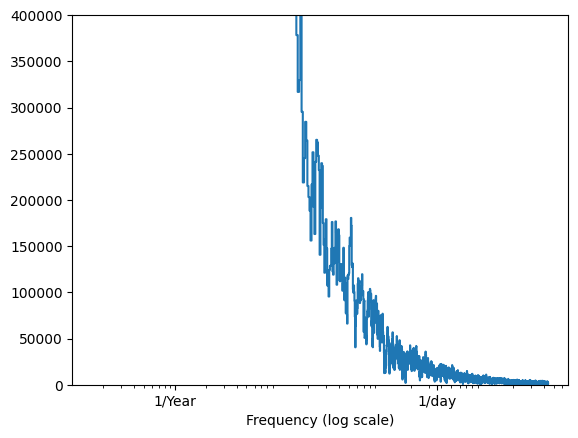

In [18]:
import tensorflow as tf
fft = tf.signal.rfft(df['Close'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Close'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [19]:
df = df[['Open', 'High', 'Low', 'Close', 'day_sin', 'day_cos', 'trend_sma_fast', 'trend_sma_slow','trend_macd', 'KF_mean']]

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.85)]
val_df = df[int(n*0.85):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

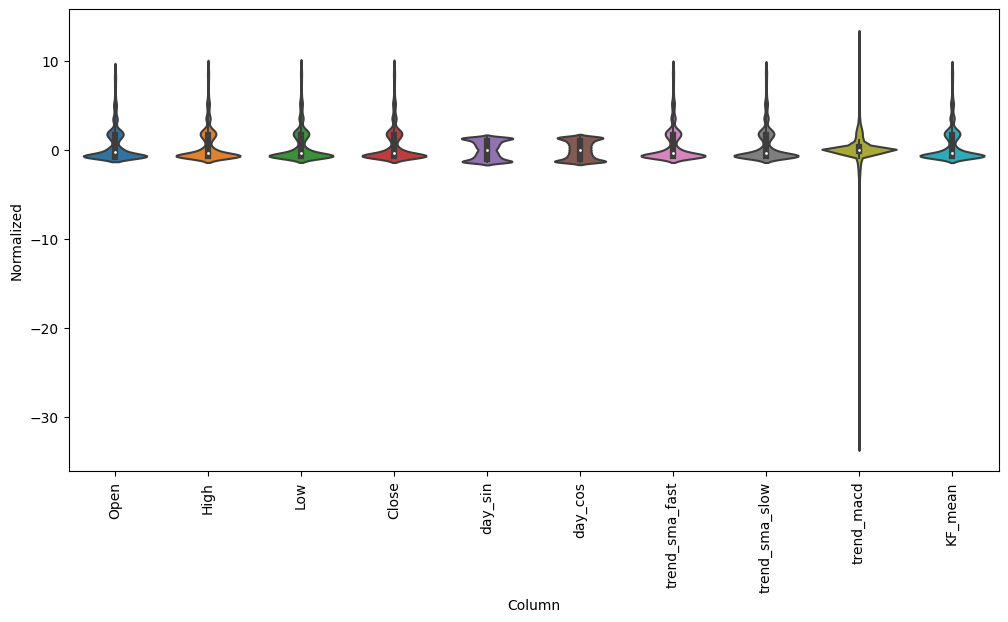

In [22]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
df.head()

,Open,High,Low,Close,day_sin,day_cos,trend_sma_fast,trend_sma_slow,trend_macd,KF_mean
25,17.230000,17.230000,17.230000,17.230000,0.988468,0.151428,17.021667,16.942692,0.121931,8.615000
26,17.209999,17.209999,17.209999,17.209999,0.998717,-0.050649,17.045833,16.963846,0.122993,11.517947
27,17.280001,17.280001,17.280001,17.280001,0.968077,-0.250653,17.080833,16.980385,0.128007,13.004682
28,17.240000,17.240000,17.240000,17.240000,0.897805,-0.440394,17.122500,16.992308,0.127286,13.899901
29,17.059999,17.059999,17.059999,17.059999,0.299363,-0.954139,17.150000,16.995385,0.110911,14.472660


In [24]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [27]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


In [28]:
w2.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

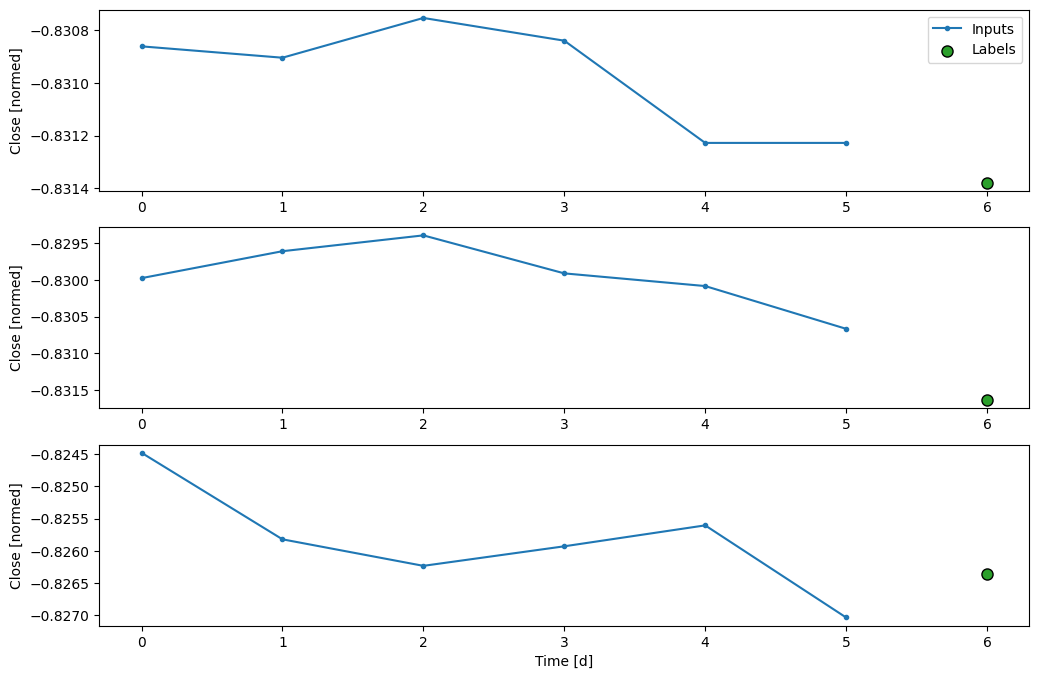

In [30]:
w2.plot()

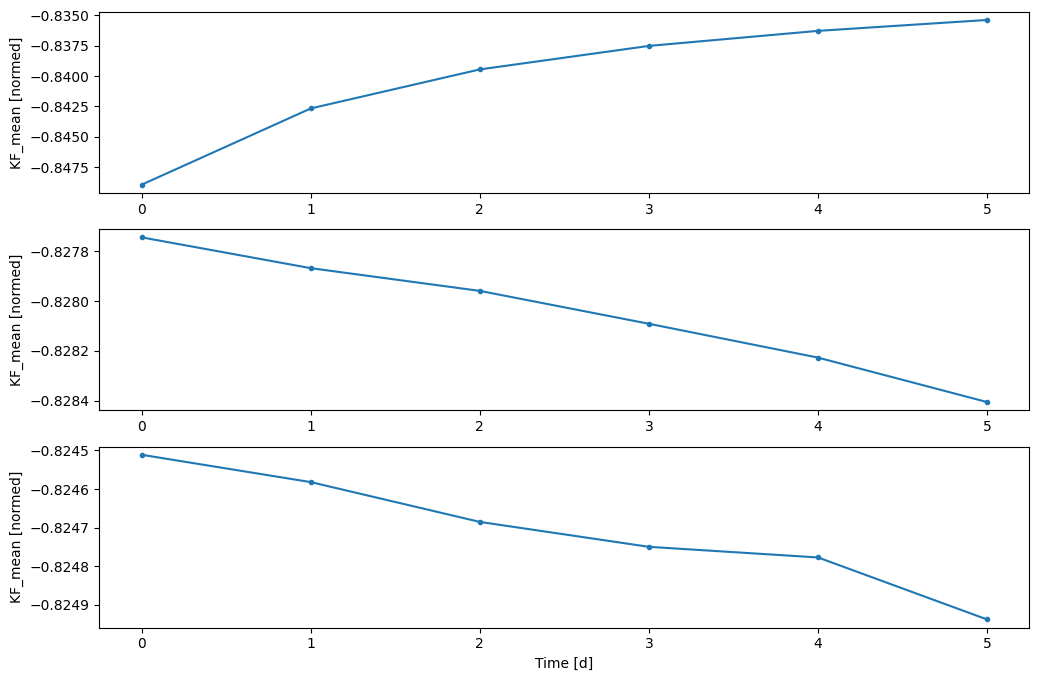

In [31]:
w2.plot(plot_col='KF_mean')

In [32]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 10)
Labels shape (batch, time, features): (32, 1, 1)


#### The following method packages the training procedure into a function

In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [37]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Close']

In [38]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer='l1'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GaussianNoise(0.001),
    tf.keras.layers.Dense(units=1)
])

In [39]:
lstm_model.build(wide_window.example[0].shape)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 30, 32)              5504      
                                                                 
 dropout (Dropout)           (32, 30, 32)              0         
                                                                 
 gaussian_noise (GaussianNoi  (32, 30, 32)             0         
 se)                                                             
                                                                 
 dense (Dense)               (32, 30, 1)               33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [40]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 10)
Output shape: (32, 30, 1)


In [41]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

57/57 [==============================] - 0s 5ms/step - loss: 0.0466 - mean_absolute_error: 0.1035


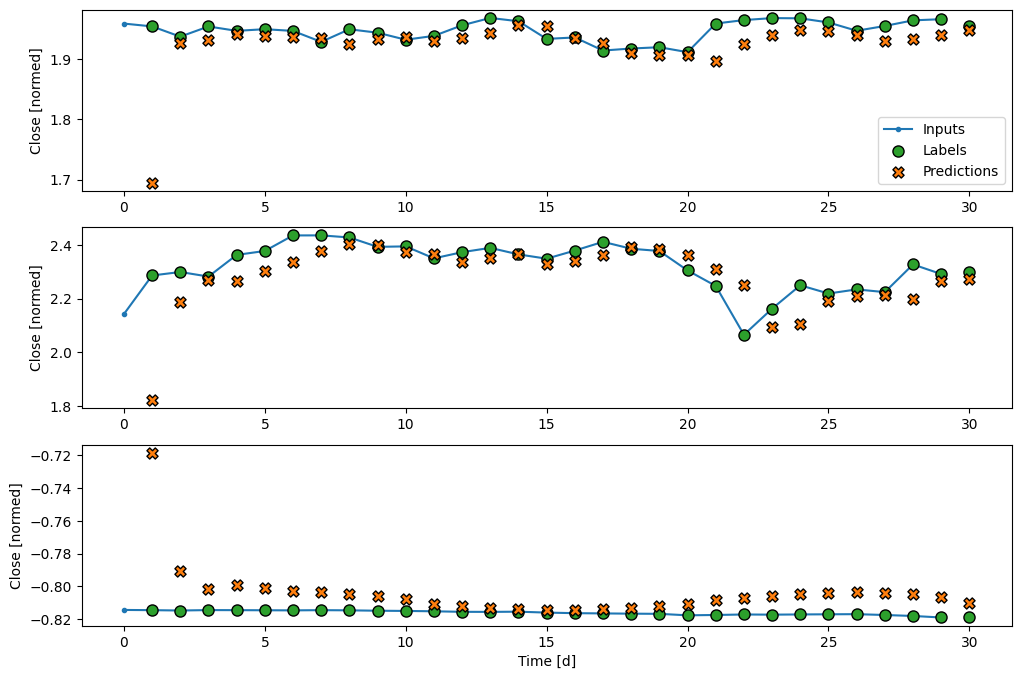

In [42]:
wide_window.plot(lstm_model)

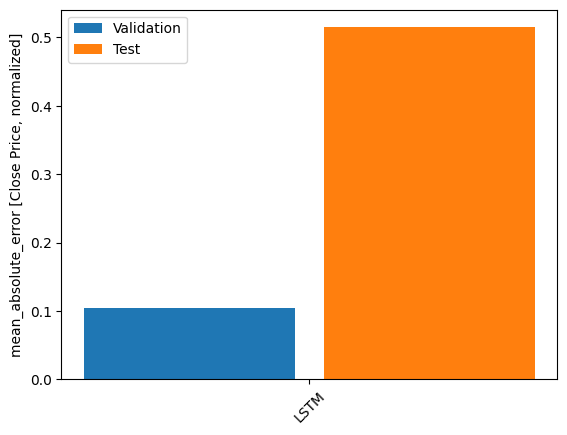

In [43]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11]
Label column name(s): None

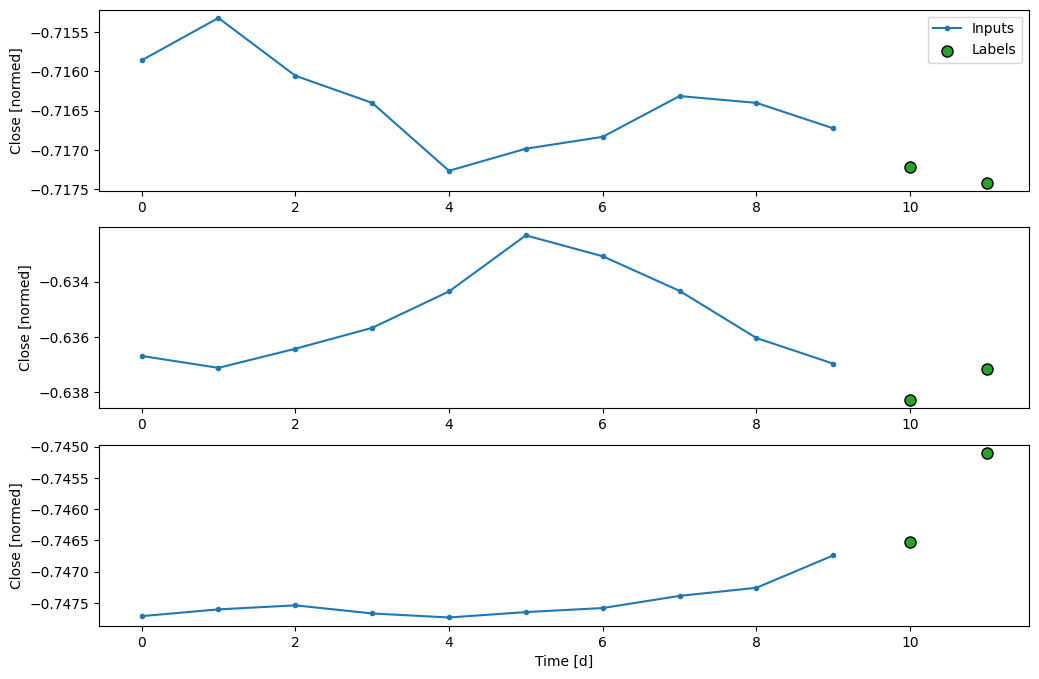

In [44]:
OUT_STEPS = 2
multi_window = WindowGenerator(input_width=10,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [45]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [46]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [47]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [48]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 10])

In [49]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [50]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 2, 10)


57/57 [==============================] - 0s 4ms/step - loss: 0.2666 - mean_absolute_error: 0.3411


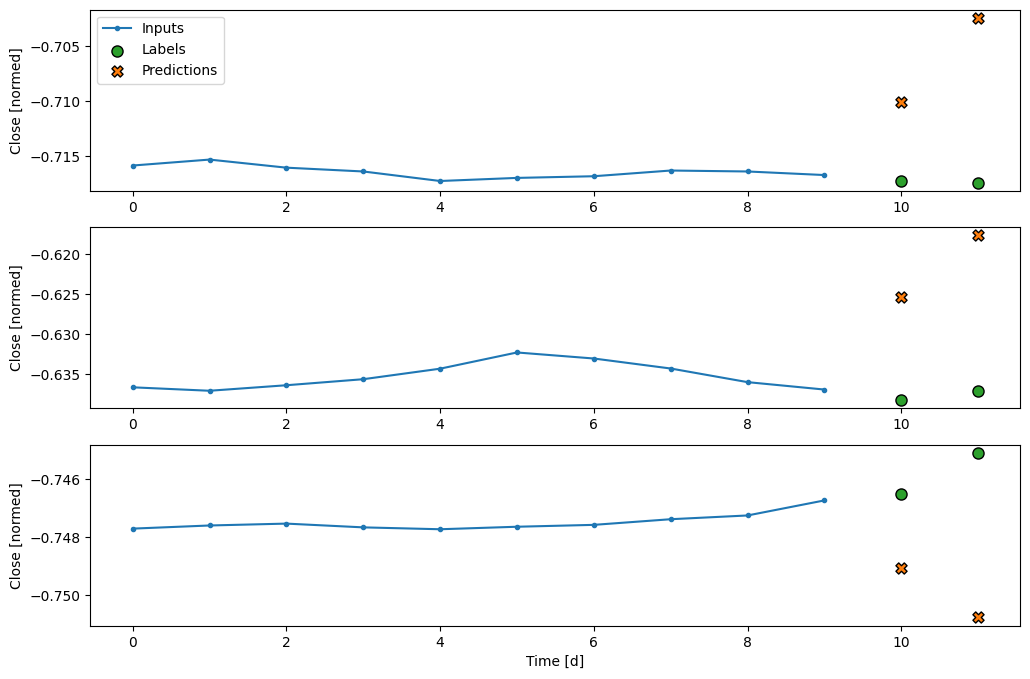

In [51]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

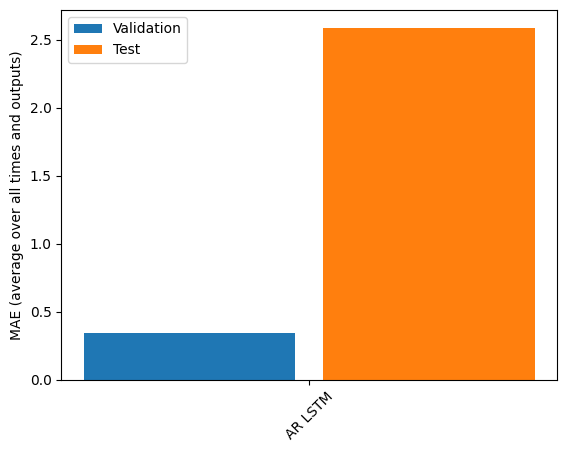

In [52]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()